In [1]:
! pip install -q seaborn

In [2]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [3]:
datasetPath=keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datasetPath

40960/30286 [========================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
columnNames=['MPG', 'Cylinders','Displacement','Horsepower','Weight',
             'Acceleration', 'Model Year', 'Origin']
rawDataSet=pd.read_csv(datasetPath, names=columnNames,
                       na_values="?", comment='\t',
                       sep=" ", skipinitialspace=True)
dataset=rawDataSet.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
#Clean data.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset=dataset.dropna()

In [7]:
origin=dataset.pop('Origin')

In [8]:
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
#Division dataset: train y test.
trainData=dataset.sample(frac=0.8, random_state=0)
testData=dataset.drop(trainData.index)

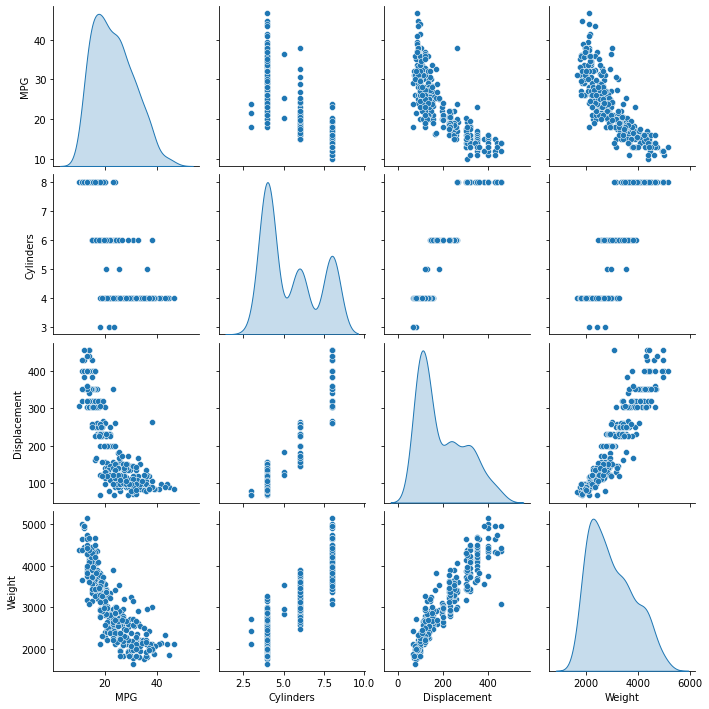

In [10]:
sns.pairplot(trainData[['MPG', 'Cylinders','Displacement','Weight']], diag_kind="kde")

In [11]:
train_stats=trainData.describe()
train_stats.pop("MPG")
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
trainLbls=trainData.pop('MPG')
testLbls=testData.pop('MPG')

In [13]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
normedTrainData=norm(trainData)
normTestData=norm(testData)

In [14]:
#Construccion modelo.
def buildModel():
    model=keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(trainData.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)                     
    ])
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [15]:
model=buildModel()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
exampleBatch=normedTrainData[:10]
exampleResult=model.predict(exampleBatch)
exampleResult

array([[ 0.04050533],
       [ 0.10877432],
       [-0.4987602 ],
       [ 0.1798208 ],
       [-0.269271  ],
       [-0.03393896],
       [-0.27528682],
       [-0.38920152],
       [-0.07757565],
       [-0.13414857]], dtype=float32)

In [18]:
#Training model.
class PrintDot(keras.callbacks.Callback):
  def onEpochEnd(self, epoch, logs):
    if epoch % 100 ==0: print('')
    print('.', end='')

EPOCHS=1000
hst=model.fit(
    normedTrainData, trainLbls,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)

In [19]:
hstry=pd.DataFrame(hst.history)
hstry['epoch']=hst.epoch
hstry.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.408236,0.958148,2.408236,9.551562,2.424136,9.551562,995
996,2.493855,1.009974,2.493855,9.216537,2.404470,9.216537,996
997,2.749238,1.025525,2.749238,9.404885,2.399955,9.404885,997
998,2.848861,1.028352,2.848861,9.613967,2.453376,9.613967,998
999,2.484385,1.001098,2.484385,9.560349,2.403834,9.560349,999


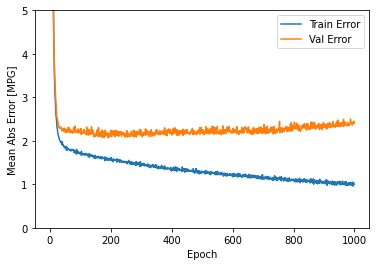

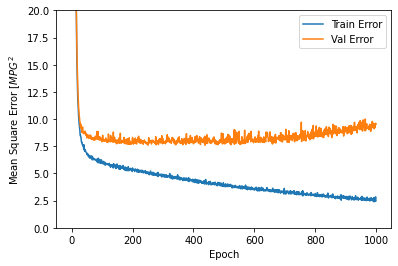

In [20]:
def plotHistory(history):
  hst=pd.DataFrame(history.history)
  hst['epoch']=history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hst['epoch'], hst['mae'],
           label='Train Error')
  plt.plot(hst['epoch'], hst['val_mae'],
           label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$')
  plt.plot(hst['epoch'], hst['mse'],
           label='Train Error')
  plt.plot(hst['epoch'], hst['val_mse'],
           label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
  
plotHistory(hst)

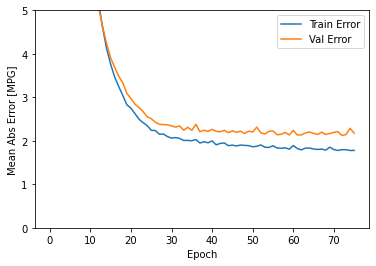

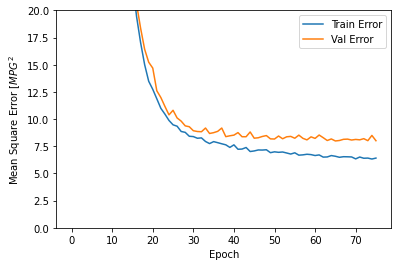

In [21]:
model=buildModel()
earlystop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=model.fit(normedTrainData, trainLbls, epochs=EPOCHS,
                  validation_split=0.2, verbose=0, callbacks=[earlystop, PrintDot()])
plotHistory(history)

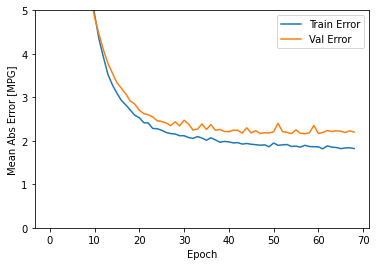

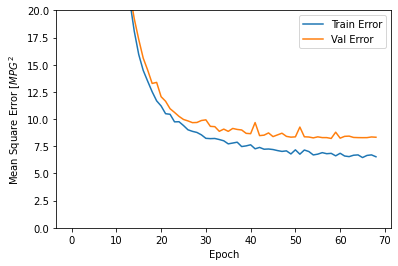

In [22]:
model=buildModel()
earlyStop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normedTrainData, trainLbls, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[earlyStop, PrintDot()])

plotHistory(history)

In [23]:
loss, mae, mse=model.evaluate(normTestData, testLbls, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7868 - mae: 1.8534 - mse: 5.7868
Testing set Mean Abs Error:  1.85 MPG


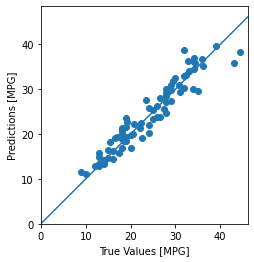

In [24]:
#Predicciones.
testPred=model.predict(normTestData).flatten()

plt.scatter(testLbls, testPred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_=plt.plot([-100, 100], [-100, 100])

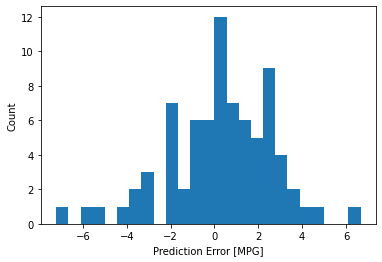

In [25]:
error=testPred-testLbls
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_=plt.ylabel("Count")